# Graph Embeddingについて学ぶ

- いくつか参考資料を漁りながら、手を動かして学んでいく。

# kerasの公式チュートリアル
- https://keras.io/examples/graph/node2vec_movielens/

## はじめに

グラフで構成されるオブジェクトから有用な表現を学習することは、社会的ネットワークやコミュニケーションネットワークの分析、生物医学研究、推薦システムなど、様々な機械学習（ML）アプリケーションに有用である。グラフ表現学習では、グラフのノードに対する埋め込み表現を学習し、ノードラベル予測（例：引用文献に基づく論文分類）やリンク予測（例：ソーシャルネットワーク上のユーザに興味あるグループを推薦する）など、様々なMLタスクに利用することを目指している。

node2vecは、グラフ内のノードの低次元埋め込みを、近傍保存目的を最適化することで学習する、シンプルでありながらスケーラブルで効果的な手法である。その目的は、グラフ構造に関して、近傍ノードの類似した埋め込みを学習することである。

データ項目がグラフ構造（項目はノード、項目間の関係はエッジで表現）になっている場合、node2vecは以下のように動作します。

- 項目列を（偏った）ランダムウォークで生成する。
- これらの列から正と負の学習例を作成する。
- 単語2vecモデル（skip-gram）を学習し、アイテムの埋め込みを学習する。
- この例では、Movielensデータセットの小型版を用いて、node2vecによる映画の埋め込みを学習するデモを行う。このようなデータセットは、映画をノードとして扱い、ユーザによる評価が類似している映画間にエッジを作成することでグラフとして表現することができる。学習された映画の埋め込みは、映画の推薦や映画のジャンル予測などのタスクに利用することができる。

この例ではnetworkxパッケージが必要です。以下のコマンドでインストールできます。

In [1]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# pandas系
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 300)
pd.options.display.float_format = '{:.5f}'.format
# 可視化系
%matplotlib inline

## MovieLensデータセットのダウンロードとデータの準備
MovieLensデータセットのスモールバージョンには、9,742本の映画に対して610人のユーザーから寄せられた約100kの評価が含まれています。

まず、データセットをダウンロードしましょう。ダウンロードしたフォルダには、users.csv、movies.csv、ratings.csvの3つのデータファイルが入っています。今回の例では、movies.datとratings.datのデータファイルのみが必要です。

In [3]:
# urlretrieve(
#     "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
# )
# ZipFile("movielens.zip", "r").extractall()

### data load

In [4]:
# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [5]:
movies

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,movie_193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,movie_193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,movie_193585,Flint (2017),Drama
9740,movie_193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [6]:
ratings

,userId,movieId,rating,timestamp
0,1,movie_1,4.00000,964982703
1,1,movie_3,4.00000,964981247
2,1,movie_6,4.00000,964982224
3,1,movie_47,5.00000,964983815
4,1,movie_50,5.00000,964982931
...,...,...,...,...
100831,610,movie_166534,4.00000,1493848402
100832,610,movie_168248,5.00000,1493850091
100833,610,movie_168250,5.00000,1494273047
100834,610,movie_168252,5.00000,1493846352


### util function

In [7]:
def get_movie_title_by_id(movieId):
    """タイトルからidを取得する"""
    return list(movies[movies.movieId == movieId].title)[0]


def get_movie_id_by_title(title):
    """idからタイトルを取得する"""
    return list(movies[movies.title == title].movieId)[0]

## ムービーグラフの構築
グラフ内の2つのムービーノードの間に、2つのムービーが同じユーザによって評価されている場合、≧min_ratingのエッジを作成します。  
エッジの重みは、2つのムービー間の点ごとの相互情報に基づいており、次のように計算されます： log(xy) - log(x) - log(y) + log(D), ここで。

- xy は、min_rating以上でで映画 x と映画 y の両方を評価したユーザの数です。
- x は、min_rating以上で映画 x を評価したユーザの数です。
- y は、min_rating以上で映画 y を評価したユーザの数です。
- D は、min_rating以上で映画が評価された合計数です。

### Step 1: create the weighted edges between movies.

In [8]:
min_rating = 5
pair_frequency = defaultdict(int)  # 各映画の組み合わせが何人のユーザーに評価されたかの辞書。 (movie1, movie2): total_rating_count
item_frequency = defaultdict(int)  # その映画を評価したユーザーが何人いるかの辞書。 movie_id:total_rating_count

# Filter instances where rating is greater than or equal to min_rating.
rated_movies = ratings[ratings.rating >= min_rating]

# Group instances by user.
movies_grouped_by_users = list(rated_movies.groupby("userId"))

for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    # 現在のループuserが見た映画idのリスト
    current_movies = list(group[1]["movieId"])

    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

Compute movie rating frequencies: 100%|██████████| 573/573 [00:00<00:00, 2234.08it/s]


In [9]:
rated_movies.head()

,userId,movieId,rating,timestamp
3,1,movie_47,5.00000,964983815
4,1,movie_50,5.00000,964982931
6,1,movie_101,5.00000,964980868
8,1,movie_151,5.00000,964984041
9,1,movie_157,5.00000,964984100


In [10]:
# 動作確認
# list(rated_movies.groupby("userId"))[0][1]["movieId"]
# item_frequency
# pair_frequency

### Step 2: create the graph with the nodes and the edges

ノード間のエッジの数を減らすために、ムービー間のエッジの重みがmin_weightよりも大きい場合のみ、エッジを追加します。  
ここでの重みは、評価ユーザー数となります。

In [11]:
min_weight = 10
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
# 映画情報の無向グラフを生成
movies_graph = nx.Graph()

# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair  # 映画の組み合わせを取得
    xy_frequency = pair_frequency[pair]  # 2つの組み合わせを両方評価したユーザー数
    x_frequency = item_frequency[x]  # 映画 x を評価したユーザの数
    y_frequency = item_frequency[y]  # 映画 y を評価したユーザの数
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency  # エッジの重み

    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

D is :9.488805094878353


Creating the movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 1203680.02it/s]


グラフのノードとエッジの総数を表示してみましょう。  
なお、他のムービーとの間にエッジを持つムービーのみが追加されるため、ノードの数はムービーの総数よりも少なくなっています。

In [13]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


グラフの平均ノード次数（隣人数）を表示してみましょう。

In [15]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 57.0


### Step 3: Create vocabulary and a mapping from tokens to integer indices

語彙は、グラフのノード（映画ID）である。

In [16]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [18]:
# 確認
# vocabulary_lookup

## 偏ったランダムウォークの実装

ランダムウォークは与えられたノードから出発し、移動先の近隣ノードをランダムに選択します。  
エッジが重み付けされている場合は、現在のノードとその近隣ノードの間のエッジの重みに関して確率的に近隣ノードが選択される。  
この手順を num_steps 分繰り返すことで、関連するノードのシーケンスを生成します。

偏ったランダムウォークは、以下の2つのパラメータを導入することで、breadth-firstサンプリング（局所的な隣人のみを訪問する）とdepth-firstサンプリング（遠方の隣人を訪問する）のバランスをとっています。

1. リターンパラメータ（p）:探索中のノードをすぐに再訪する可能性を制御します．高い値を設定すると適度な探索が行われ、低い値を設定すると局所的な探索が行われる。
2. In-outパラメータ（q）:内向きのノードと外向きのノードを区別することができます。高い値を設定するとランダムウォークがローカルノードに偏り、低い値を設定すると遠くのノードを訪れるようになります。

In [19]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]

    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        
        # ランダムに最初のノードを決定するためにシャッフル
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

### 偏ったランダムウォークを使って学習データを生成する
pとqの設定を変えることで、関連する映画の結果を変えることができます。

In [20]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5

# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:02<00:00, 692.00it/s]

Number of walks generated: 7025


In [23]:
# シーケンスデータが作成されている
walks[:5]

[[1341, 978, 921, 273, 361, 940, 17, 655, 737, 670],
 [159, 134, 850, 845, 848, 266, 482, 1085, 1, 378],
 [1321, 604, 346, 319, 547, 752, 47, 48, 23, 858],
 [683, 273, 823, 137, 433, 743, 317, 210, 34, 125],
 [845, 53, 1054, 176, 327, 14, 670, 366, 833, 670]]

### 正例と負例の生成
スキップグラムモデルを学習するために、生成されたウォークを使って、正と負の学習例を作成します。各例題には以下の特徴が含まれています。

- ターゲット。歩行シーケンス内のムービー。
- context: 歩き方に含まれる別のムービー。
- weight: この2つの映画が歩行シークエンスの中で何回出現したか。
- label この2つのムービーが歩行シークエンスのサンプルであればラベルは1、そうでなければ（つまりランダムにサンプリングされていれば）ラベルは0となる。

In [24]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 7025/7025 [00:05<00:00, 1340.33it/s]


In [28]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (883328,)
Contexts shape: (883328,)
Labels shape: (883328,)
Weights shape: (883328,)


## Convert the data into tf.data.Dataset objects

In [30]:
batch_size = 1024

def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

## スキップ・グラム・モデルの学習

スキップ・グラムは、次のように動作するシンプルな二値分類モデルです。

対象となる映画について、埋め込みが検索される。  
コンテキスト・ムービーのための埋め込みが検索される。  
この2つのエンベッディングの間のドットプロダクトが計算されます。  
その結果（シグモイド活性化の後）をラベルと比較します。  
バイナリークロスエントロピー損失が用いられる。  

In [31]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

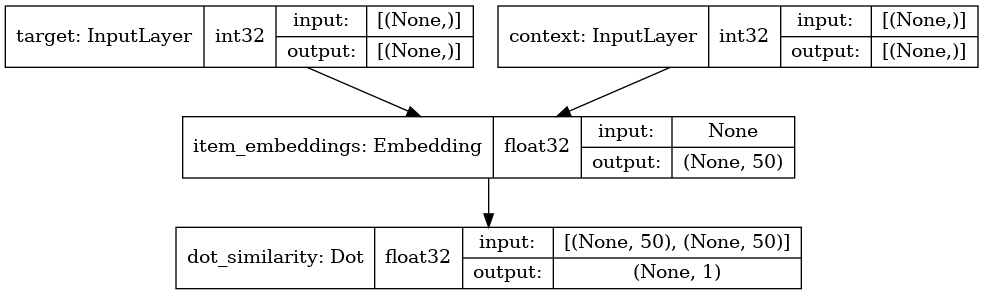

In [32]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

keras.utils.plot_model(
    model, show_shapes=True, show_dtype=True, show_layer_names=True,
)

In [33]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
862/862 [==============================] - 2s 2ms/step - loss: 2.4496
Epoch 2/10
862/862 [==============================] - 1s 2ms/step - loss: 2.3399
Epoch 3/10
862/862 [==============================] - 1s 2ms/step - loss: 2.3326
Epoch 4/10
862/862 [==============================] - 1s 2ms/step - loss: 2.3282
Epoch 5/10
862/862 [==============================] - 1s 2ms/step - loss: 2.3237
Epoch 6/10
862/862 [==============================] - 1s 2ms/step - loss: 2.3197
Epoch 7/10
862/862 [==============================] - 1s 2ms/step - loss: 2.3164
Epoch 8/10
862/862 [==============================] - 1s 2ms/step - loss: 2.3135
Epoch 9/10
862/862 [==============================] - 1s 2ms/step - loss: 2.3111
Epoch 10/10
862/862 [==============================] - 1s 2ms/step - loss: 2.3087


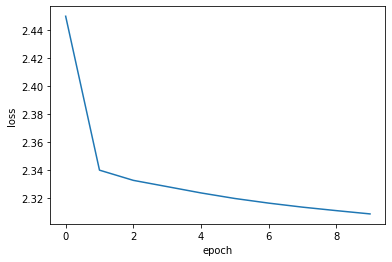

In [34]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Analyze the learnt embeddings.

In [35]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 50)


## 関連ムービーの検索
query_moviesという、いくつかの映画を含むリストを定義します。

In [36]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

In [37]:
# query_moviesに含まれる映画のエンベッディングを取得する。
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [39]:
query_embeddings.shape

(5, 50)

query_moviesの埋め込みと他の全ての映画の埋め込みとのコンサイン類似度を計算し、それぞれ上位k位を選ぶ。

In [40]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

query_moviesの中から、関連する上位のムービーを表示します。

In [41]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

Matrix, The (1999)
------------------
- Matrix, The (1999)
- Forrest Gump (1994)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Dark Knight, The (2008)
- Star Wars: Episode VI - Return of the Jedi (1983)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Forrest Gump (1994)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Braveheart (1995)
- Star Wars: Episode IV - A New Hope (1977)
- Star Wars: Episode VI - Return of the Jedi (1983)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Independence Day (a.k.a. ID4) (1996)
- Die Hard: With a Vengeance (1995)
- Ghost (1990)
- Forrest Gump (1994)

Terminator 2: Judgment Day (1991)
---------------------------------
- Forrest Gump (1994)
- Braveheart (1995)
- Terminator 2: Judgment Day (1991)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Star Wars: Episode VI - Return of the Jedi (1

## Visualize the embeddings using the Embedding Projector

In [42]:
import io

out_v = io.open("embeddings.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for idx, movie_id in enumerate(vocabulary[1:]):
    movie_title = list(movies[movies.movieId == movie_id].title)[0]
    vector = movie_embeddings[idx]
    out_v.write("\t".join([str(x) for x in vector]) + "\n")
    out_m.write(movie_title + "\n")

out_v.close()
out_m.close()